Night Sky Object Identification and Mapping

In [ ]:
!wget https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5

--2023-05-21 17:21:22--  https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2735267419 (2.5G)
Saving to: ‘Galaxy10_DECals.h5’

Galaxy10_DECals.h5  100%[===================>]   2.55G  45.4MB/s    in 58s     

2023-05-21 17:22:20 (45.3 MB/s) - ‘Galaxy10_DECals.h5’ saved [2735267419/2735267419]



In [ ]:
!pip install tensorflow

In [ ]:
import h5py
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import utils

In [ ]:
def load_galaxy10_subset(start, end):
    with h5py.File('Galaxy10_DECals.h5', 'r') as f:
        # Load the images and labels between the start and end indices
        images = np.array(f['images'][start:end])
        labels = np.array(f['ans'][start:end])

    # Convert the labels to categorical
    labels = utils.to_categorical(labels, 10)

    # Convert to desirable type
    labels = labels.astype(np.float32)
    images = images.astype(np.float32)

    return images, labels

In [ ]:
import matplotlib.pyplot as plt

# Define the class names
class_names = ['Disturbed Galaxies', 'Merging Galaxies', 'Round Smooth Galaxies', 'In-between Round Smooth Galaxies', 'Cigar Shaped Smooth Galaxies', 'Barred Spiral Galaxies', 'Unbarred Tight Spiral Galaxies', 'Unbarred Loose Spiral Galaxies', 'Edge-on Galaxies without Bulge', 'Edge-on Galaxies with Bulge']

def display_image(images, labels, index):
    # Display the image
    plt.figure()
    plt.imshow(images[index])
    plt.colorbar()
    plt.grid(False)
    plt.title("Class: " + class_names[np.argmax(labels[index])])
    plt.show()

In [ ]:
images, labels = load_galaxy10_subset(0, 3000)
images = images.astype(np.float32) / 255

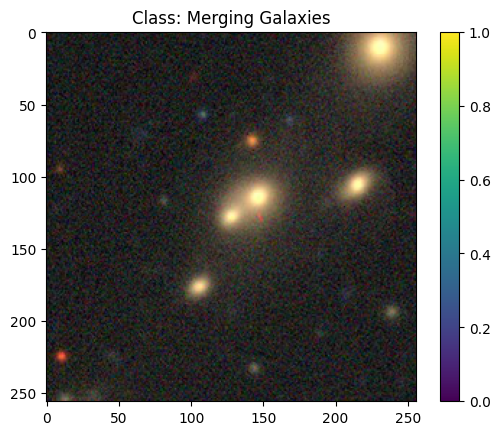

In [ ]:
display_image(images, labels, 1480)

In [95]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from scipy.stats import rv_discrete

In [107]:
stars_per_magnitude = {
    2.0: 48,
    3.0: 171,
    4.0: 513,
    5.0: 1602,
    6.0: 4800,
    7.0: 14000,
    8.0: 42000,
    9.0: 121000,
    10.0: 340000,
    11.0: 725346,
    12.0: 1374412,
    13.0: 2378009,
    14.0: 3844017,
    15.0: 5894386,
    16.0: 8665135,
    17.0: 12306357,
    18.0: 16982212,
    19.0: 22870933,
    20.0: 30164822,
}

def count_stars_in_range(start_magnitude: float, end_magnitude: float):
    total_stars = 0
    for magnitude in range(int(start_magnitude), int(end_magnitude) + 1):
        total_stars += stars_per_magnitude.get(magnitude, 0)
    return total_stars

def field_of_view(chip_size_mm: float, focal_length_mm: float) -> float:
    # Formula for field of view in arcminutes, considering focal length in mm
    fov = (57.3 * chip_size_mm) / focal_length_mm
    return fov

def check_star_visibility(aperture: float, exposure_time: float):
    # Define parameters
    max_brightness = 255  # Maximum star brightness (8-bit scale)
    magnitude_buckets = [(20, 21), (19, 20), (18, 19), (17, 18), (16, 17), (15, 16), (14, 15), (13, 14), (12, 13), (11, 12), (10, 11), (9, 10), (8, 9), (7, 8), (6, 7), (5, 6), (4, 5), (3, 4), (2, 3), (1, 2), (0, 1), (-1, 0)]

    # Check star visibility
    for min_magnitude, max_magnitude in magnitude_buckets:  # iterate over each magnitude bucket from dimmest to brightest
        # Determine star brightness based on exposure time and aperture
        brightness = 10 ** (-max_magnitude / 2.5)  # generate a star at the dimmest edge of the current bucket

        # Adjust brightness according to exposure time and aperture
        exposure_factor = exposure_time  # The longer the exposure time, the more light is collected
        aperture_factor = aperture**2  # The effectiveness of aperture is proportional to the square of its diameter
        brightness *= exposure_factor * aperture_factor

        # Make sure brightness is within acceptable limits
        brightness = np.clip(brightness, 0, max_brightness)

        # If the star is bright enough to be seen, record it
        if brightness > 1:  # or whatever threshold you deem appropriate
            return max_magnitude
            break  # Breaks the loop as soon as we find a visible star, assuming all brighter stars are also visible

def generate_stars(min_magnitude, percent_of_sky):
    # Number of stars to generate
    num_stars = int(count_stars_in_range(0, min_magnitude) * percent_of_sky)

    # List to hold the ranges of magnitudes
    magnitude_ranges = [(i, i+1, count_stars_in_range(i, i+1)*percent_of_sky) for i in range(0, min_magnitude)]

    stars = []
    for _ in range(num_stars):
        # Generate a random number to determine the magnitude bracket
        rand_number = random.random() * num_stars

        # Determine the bracket the random number falls into
        total = 0
        for mag_range in magnitude_ranges:
            total += mag_range[2]
            if rand_number <= total:
                break

        # Assign a magnitude to the star within the selected range
        magnitude = random.uniform(mag_range[0], mag_range[1])

        # Assign random coordinates to the star
        coord_x = random.random() * 100  # Percentage from left to right
        coord_y = random.random() * 100  # Percentage from bottom to top

        # Append the star (represented as a dictionary) to the list
        stars.append({"magnitude": magnitude, "coordinates": (coord_x, coord_y)})
    
    return stars

def add_noise_to_image(image: np.ndarray, desired_snr: float):
    # Calculate the signal (mean of the image)
    signal = np.mean(image)

    # Calculate the noise level based on the desired SNR
    noise_std = signal / desired_snr

    # Generate noise
    noise = np.random.normal(scale=noise_std, size=image.shape)

    # Add noise to the image
    noisy_image = image + noise

    # Ensure pixel values are within valid range
    noisy_image = np.clip(noisy_image, 0, 255)

    return noisy_image

def create_star_image(stars, image_size):
    # Create a black image
    image = np.zeros(image_size, dtype=np.uint8)

    # Calculate the maximum star magnitude
    max_magnitude = max(star['magnitude'] for star in stars)

    # Map each star onto the image
    for star in stars:
        # Calculate star brightness
        # We'll scale the brightness so that the brightest star has a pixel value of 255
        brightness = int((1 - (star['magnitude'] / max_magnitude)) * 255)

        # Calculate the position of the star in the image
        # We'll assume the coordinates are percentages of the image size
        position = (int(star['coordinates'][1] / 100 * image_size[1]),  # the y-coordinate is the first index in numpy arrays
                    int(star['coordinates'][0] / 100 * image_size[0]))  # the x-coordinate is the second index in numpy arrays

        # Set the pixel at the star's position to the star's brightness
        image[position] = brightness
    
    return image

In [100]:
aperture=200
focal_len=1040
exposure_time= 10
chip_size = 22.3
fov = field_of_view(chip_size, focal_len)
fov2 = fov*fov
percentOfSky = ((fov2)/41253)
print(f"FoV = {fov} degrees which is {fov2} degrees squared or {percentOfSky} % of night sky.")
minMagnitude = check_star_visibility(aperture, exposure_time)
print(minMagnitude)
print(count_stars_in_range(0, minMagnitude)*percentOfSky)

FoV = 1.2286442307692307 degrees which is 1.5095666458025145 degrees squared or 3.659289374839441e-05 % of night sky.
14
323.6977374810096


In [ ]:
stars = generate_stars(minMagnitude, percentOfSky)

In [109]:
image = create_star_image(stars, 1200)

TypeError: ignored